In [1]:
import pandas as pd

In [11]:
df = pd.read_csv("/home/clay/research/kaggle/sennet/data/blood-vessel-segmentation/train_rles.csv")
df["label_len"] = df["rle"].str.len()

In [13]:
df.sort_values("label_len", ascending=False).head()

,id,rle,label_len
3591,kidney_1_voi_1312,240506 4 242433 7 244362 8 246290 10 248218 11...,19935
3590,kidney_1_voi_1311,236650 1 238577 3 240505 5 242434 6 244362 8 2...,19788
3592,kidney_1_voi_1313,240507 3 242434 6 244362 8 246290 10 248218 11...,19776
3587,kidney_1_voi_1308,234720 1 236648 3 238575 5 240503 7 242431 9 2...,19763
3589,kidney_1_voi_1310,236649 2 238577 4 240505 5 242433 7 244360 10 ...,19747


In [15]:
df.loc[3591, "rle"]

'240506 4 242433 7 244362 8 246290 10 248218 11 250146 13 252071 18 253999 20 255926 22 257854 24 259782 26 261709 28 263635 32 265563 34 267490 36 269418 38 271345 41 273273 42 275201 44 277128 47 279055 49 280982 52 282910 53 284837 56 286765 58 288693 59 290620 62 292546 65 294473 68 296401 69 298102 2 298328 72 300028 4 300255 75 301954 6 302183 76 303882 6 303895 1 304111 78 305809 7 305822 3 306038 80 307736 8 307750 4 307966 82 309663 12 309678 4 309893 84 311591 19 311821 86 313519 19 313749 87 315447 19 315676 90 317375 20 317604 91 319303 20 319531 93 321231 20 321459 94 323159 20 323386 94 325087 20 325314 94 327014 21 327242 93 328942 21 329169 93 330871 20 331096 93 332799 20 333023 94 334728 19 334951 93 336656 19 336878 94 338584 18 338805 94 340512 18 340733 93 342440 17 342661 93 344368 16 344588 94 346297 15 346516 94 348226 13 348442 95 350157 7 350370 94 352088 4 352297 95 354225 94 356152 95 358080 94 360007 95 361935 94 363861 96 365789 95 367715 97 369642 97 3715

In [18]:
import numpy as np


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


In [19]:
mask = rle_decode(df.loc[3591, "rle"], (1928, 1928))

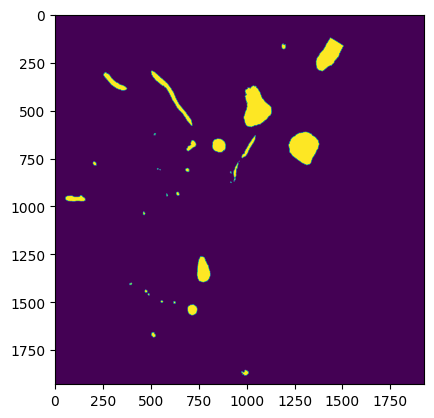

In [20]:
import matplotlib.pyplot as plt


plt.imshow(mask)

In [62]:
import cv2
from pathlib import Path
from sklearn.mixture import GaussianMixture

len(img_paths) = 1397
img_path = '/home/clay/research/kaggle/sennet/data/blood-vessel-segmentation/train/kidney_1_voi/images/0900.tif'
img.shape=(1928, 1928)


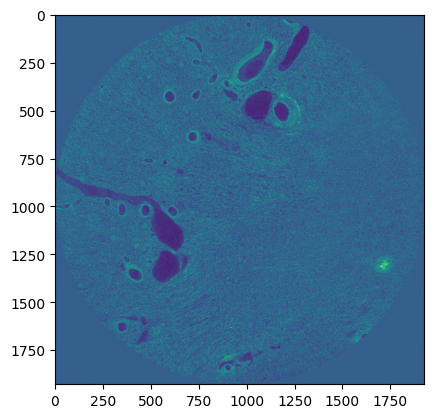

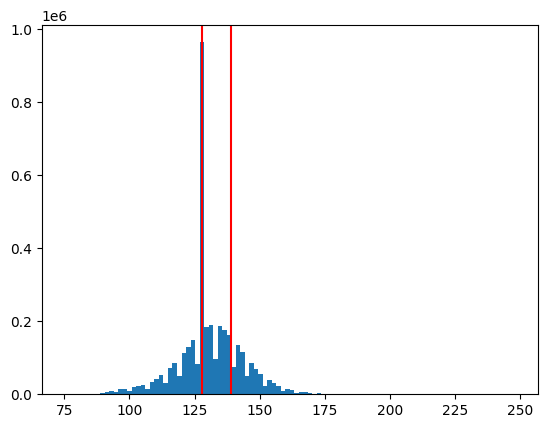

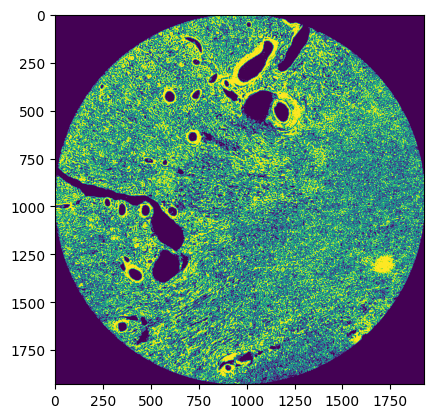

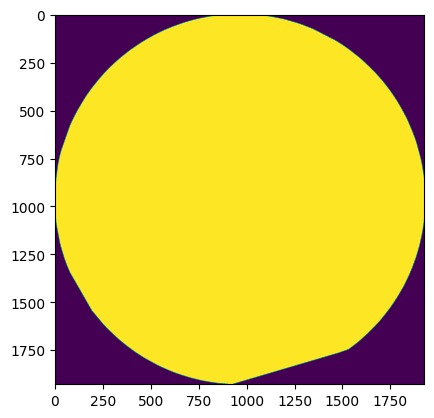

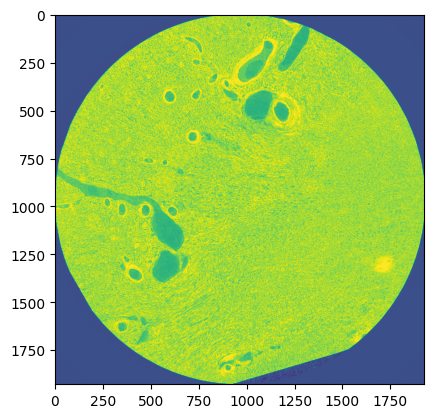

In [87]:
dir_name = "kidney_1_voi"
# dir_name = "kidney_3_sparse"
img_paths = sorted(list(Path(f"/home/clay/research/kaggle/sennet/data/blood-vessel-segmentation/train/{dir_name}/images").glob("*")))
print(f"{len(img_paths) = }")
i = 900
img_path = str(img_paths[i])
print(f"{img_path = }")

plt.close()

img = cv2.imread(img_path, 0)
print(f"{img.shape=}")
plt.figure()
plt.imshow(img)

flattened_img = img.flatten()
plt.figure()
_ = plt.hist(flattened_img, bins=100)

gmm = GaussianMixture(n_components=2)
gmm.fit(flattened_img.reshape((-1, 1)))
for m in gmm.means_:
    plt.axvline(m, color="red")
bin_freq, bin_edges = np.histogram(flattened_img, bins=50)

sorted_means = sorted(gmm.means_)
idx0 = np.argmin(np.abs(bin_edges - sorted_means[0]))
idx1 = np.argmin(np.abs(bin_edges - sorted_means[1]))
split_val = bin_edges[np.argmin(bin_freq[idx0: idx1]) + idx0]

thr = split_val
mask = ((img > thr) * 255).astype(np.uint8)
plt.figure()
plt.imshow(mask)

# kernel_size = 11
# mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((kernel_size, kernel_size), np.uint8))
contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
mask[:] = 0
for c in contours:
    hull = cv2.convexHull(c)
    area = cv2.contourArea(hull)
    if area / img.shape[0] / img.shape[1] < 0.1:
        continue
    mask = cv2.drawContours(mask, [hull], 0, 255, -1)

mask = mask > 0
mask[0, 0] = 0  # just to trigger the plt gradient

plt.figure()
plt.imshow(mask)
plt.figure()
plt.imshow(np.clip(img + 100 * mask, 0, 255))

In [70]:
bin_freq, bin_edges = np.histogram(flattened_img, bins=50)

sorted_means = sorted(gmm.means_)
idx0 = np.argmin(np.abs(bin_edges - sorted_means[0]))
idx1 = np.argmin(np.abs(bin_edges - sorted_means[1]))
split_val = bin_edges[np.argmin(bin_freq[idx0: idx1]) + idx0]
print(split_val)

89.26
